<center><img src="sample_image/pizza_header.png" alt="Pizza Image" width="900" height="300"></center>

<center><span style="color: gray;"><em>Image Generated from Microsoft Designer: Prompt = "pizza painting, extreme wide view, oversaturated filter"</em></span></center>

<center><h1>Slice or Not?</h1></center>
<center><em>Fine-tuning a Deep Learning Model for Delectable Pizza Detection!</em></center>


Are you ready to embark on an irresistible journey into the world of deep learning and culinary delight? In this mouthwatering journey, we delve into the art of binary classification, where our goal is to train a remarkable deep learning model to distinguish between images that make us crave a slice of cheesy heaven and those that leave us wanting more. With a sprinkle of data preprocessing, a dash of model architecture design, and a generous serving of fine-tuning techniques, we'll uncover the secret sauce to achieving scrumptious accuracy in detecting pizzas like never before. Prepare your taste buds, because this will have you craving not just answers but a slice of the action!

***

<a name="top"></a>
#### Table of Contents:

[ref0]: #Dataset_Preparation
- [Dough Preparation][ref0]

[ref1]: #Data_Pre-processing
- [Kneading the Dough][ref1]

[ref3]: #Feature_Extraction
- [Selecting the Ingridients][ref3]

[ref4]: #Fine_Tuning
- [Turning our model to a Pizzaiolo][ref4]

***

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os, shutil
import torchvision
import time
import copy

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
from torchsummary import summary

from PIL import Image
from pathlib import Path

<a name="Dataset_Preparation"></a>
#### Phase 1: Dough Preparation
***
In the exhilarating quest to create a pizza-detecting deep learning model, the first crucial step is dataset preparation. Just like a master chef carefully selects the finest ingredients, we meticulously curate a diverse and tantalizing collection of images, comprising both pizza and non-pizza samples. From tantalizing margheritas to mouthwatering meat lovers, every slice captured in our dataset represents a delectable piece of culinary art. The dataset utilized for this project was obtained from Kaggle. Specifically, the dataset "Pizza, Not Pizza" by Carlos Runner from https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza. This dataset forms the foundation of our pizza detection model, enabling us to train our deep learning algorithms to differentiate between images of pizzas and non-pizzas accurately.

In [3]:
pizza_path = './pizza_not_pizza/pizza'
not_pizza_path = './pizza_not_pizza/not_pizza'

paths = [pizza_path, not_pizza_path]

# # this section should be manually changed depending on which
# # directory you are trying to rename
# count = 1
# for filename in os.listdir(not_pizza_path):
#     if filename.endswith('.jpg'):
#         new_name = f'not_pizza.{count}.jpg'
#         os.rename(os.path.join(not_pizza_path, filename),
#                   os.path.join(not_pizza_path, new_name))
#         count += 1

In [4]:
# before creating a dataset let's see first how many
# images are there in each directory

def count_files(directory):
    """
    Count the number of files in a directory.

    Args:
        directory (str): The path to the directory.

    Returns:
        int: The total number of files in the directory.
    """
    file_count = 0
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isfile(item_path):
            file_count += 1
    return file_count


for dir_path in paths:
    files_count = count_files(dir_path)
    print(f"Number of images in '{dir_path}': {files_count}")

Number of images in './pizza_not_pizza/pizza': 983
Number of images in './pizza_not_pizza/not_pizza': 983


In [5]:
def create_dataset(src, dst, range_, class_):
    """
    Create a dataset by copying files from a source directory
    to a destination directory.

    Args:
        src (str): The path to the source directory
                   containing the original files.
        dst (str): The path to the destination directory
                   where the copied files will be saved.
        range_ (tuple): A tuple representing the range of
                        file indices to be included in the dataset.
        class_ (str): The class label or name of the files.

    Returns:
        None
    """
    if os.path.exists(dst):
        shutil.rmtree(dst)
    os.makedirs(dst)
    fnames = [f'{class_}.{i}.jpg' for i in range(*range_)]
    for fname in fnames:
        src_file = os.path.join(src, fname)
        dst_file = os.path.join(dst, fname)
        shutil.copyfile(src_file, dst_file)

In [6]:
# looping through create_dataset for each class
classes = ['pizza', 'not_pizza']

for class_ in classes:
    src = 'pizza_not_pizza'
    
    dst = f'pizza_not_pizza/train/{class_}' # train
    create_dataset(src+'/'+class_, dst, range_=(1, 589), class_=class_)

    dst = f'pizza_not_pizza/validation/{class_}' # val
    create_dataset(src+'/'+class_, dst, range_=(589, 785), class_=class_)
    
    dst = f'pizza_not_pizza/test/{class_}' # test
    create_dataset(src+'/'+class_, dst, range_=(785, 983), class_=class_)

In [7]:
train_pizza_dir =  'pizza_not_pizza/train/pizza'
train_not_pizza_dir =  'pizza_not_pizza/train/not_pizza'

validation_pizza_dir = 'pizza_not_pizza/validation/pizza'
validation_not_pizza_dir = 'pizza_not_pizza/validation/not_pizza'

test_pizza_dir = 'pizza_not_pizza/test/pizza'
test_not_pizza_dir = 'pizza_not_pizza/test/not_pizza'

In [8]:
print('total training Pizza images:', len(os.listdir(train_pizza_dir)))
print('total training Non Pizza images:', len(os.listdir(train_not_pizza_dir)))

print('total validation Pizza images:', len(os.listdir(validation_pizza_dir)))
print('total validation Non Pizza images:', len(os.listdir(validation_not_pizza_dir)))

print('total test Pizza images:', len(os.listdir(test_pizza_dir)))
print('total test Non Pizza images:', len(os.listdir(test_not_pizza_dir)))

total training Pizza images: 588
total training Non Pizza images: 588
total validation Pizza images: 196
total validation Non Pizza images: 196
total test Pizza images: 198
total test Non Pizza images: 198


In [9]:
data_path = Path("pizza_not_pizza")
image_path = data_path

image_path_list = list(image_path.glob("*/*/*.jpg"))

train_dir = image_path / "train"
val_dir = image_path / "validation"
test_dir = image_path / "test"

train_dir, val_dir, test_dir

(PosixPath('pizza_not_pizza/train'),
 PosixPath('pizza_not_pizza/validation'),
 PosixPath('pizza_not_pizza/test'))

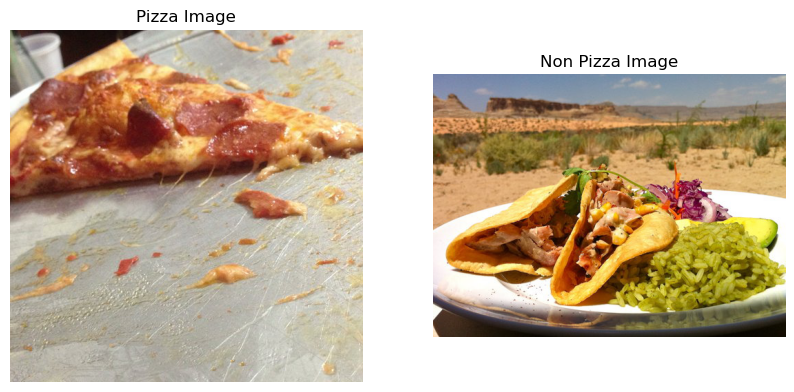

In [10]:
pizza_image = Image.open('pizza_not_pizza/train/pizza/pizza.100.jpg')
not_pizza_image = Image.open('pizza_not_pizza/train/not_pizza/not_pizza.100.jpg')

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(pizza_image)
ax1.set_title('Pizza Image')
ax1.axis('off')
ax2.imshow(not_pizza_image)
ax2.set_title('Non Pizza Image')
ax2.axis('off');

[ref]: #top
[Back to Table of Contents][ref]

<a name="Data_Pre-processing"></a>
#### Phase 2: Kneading the Dough
***

Just like preparing the dough before it transforms into a mouthwatering pizza, data pre-processing lays the foundation for training our deep learning model. In this section, we explore the essential steps involved in transforming and augmenting our dataset to enhance model performance. First, we dive into resizing our images to a standard size of 224x224 pixels using the transformative power of PyTorch's transforms.Resize and convert them into tensors using transforms.ToTensor. As we strive to create a robust model, we also calculate the means and standard deviations of the image dataset to normalize the pixel values, ensuring optimal training conditions.

In [11]:
data_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transforms)

imgs = torch.stack([img_t for img_t, _ in train_data], dim=3)
means = imgs.view(3, -1).mean(dim=1).numpy()
stds = imgs.view(3, -1).std(dim=1).numpy()

print(f'Means:           {means}') 
print(f'Std. Deviations: {stds}')

Means:           [0.5573784  0.42671558 0.3222913 ]
Std. Deviations: [0.25985646 0.2596772  0.264706  ]


With the pre-processing steps in place, we then proceed to build custom transformation pipelines for different data subsets: training, validation, and testing. These pipelines incorporate additional data augmentation techniques, such as random horizontal flipping, perspective transformations, and color jittering, adding a pinch of variation to our training process.

To bring it all together, we leverage the flexibility of PyTorch's ImageFolder to load our transformed dataset, organizing it into separate subsets. With the help of data loaders, we create mini-batches, shuffling the data during training to enhance model generalization. Additionally, we compute the sizes of each dataset subset and capture the class names from the training set, empowering us to interpret the model's predictions later.

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomHorizontalFlip(p=0.6),             
        transforms.RandomPerspective(p=0.5),
        transforms.ColorJitter(brightness=0.5),              
        transforms.ToTensor(),                              
        transforms.Normalize(means, stds)
    ]),
    'validation': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),                              
        transforms.Normalize(means, stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),                              
        transforms.Normalize(means, stds)
    ])
}

data_dir = 'pizza_not_pizza'

# loading image data using ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation', 'test']}

# dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4,
                             shuffle=True)
              for x in ['train', 'validation', 'test']}
# size of datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

# class names
class_names = image_datasets['train'].classes

print(f'The classes in our dataset are the following:\n{class_names}')

The classes in our dataset are the following:
['not_pizza', 'pizza']


[ref]: #top
[Back to Table of Contents][ref]

<a name="Feature_Extraction"></a>
#### Phase 3: Selecting the Ingridients
***
Just as a skilled pizzaiolo meticulously selects the finest toppings, we delve into the intricate architecture of our pre-trained model to unveil its latent abilities. To tackle the task of pizza classification, we have carefully selected the powerful ResNet-18 model from the torchvision library as our base architecture. ResNet-18 is an excellent choice due to its impressive performance and efficiency, making it a well-suited candidate for our dataset.

One of the primary reasons we opted for ResNet-18 over ResNet-50 is the size of our dataset. With 1000 images of pizza and 1000 images of non-pizza, our dataset is relatively small compared to the millions of images used to train models like ResNet-50 on the ImageNet dataset. ResNet-50, being a deeper and more complex network, is prone to overfitting when trained on limited data. In contrast, ResNet-18 strikes a balance between model capacity and computational efficiency, making it more suitable for smaller datasets like ours.

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [14]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1') 
for param in model_conv.parameters():
    param.requires_grad = False

In [15]:
print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
summary(model_conv, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

In [17]:
num_ftrs = model_conv.fc.in_features

model_conv.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 2)  
)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.parameters(),
                           lr=0.001,
                           momentum=0.9)

In [18]:
summary(model_conv, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

In [19]:
def train_model_with_patience(model, criterion, optimizer,
                num_epochs=25, patience=2, delta=0.001):
    """
    Trains a model with early stopping based on validation loss.

    Parameters:
        model (torch.nn.Module): The model to be trained.
        criterion: Loss function to optimize.
        optimizer: Optimizer for updating model parameters.
        num_epochs (int): Number of epochs to train the model (default: 25).
        patience (int): Number of epochs to wait for improvement in
                        validation loss before early stopping (default: 2).
        delta (float): Minimum change in validation loss to be
                       considered as improvement (default: 0.001).

    Returns:
        torch.nn.Module: The trained model.
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = np.Inf
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'validation':
                if epoch_loss < best_loss - delta:
                    best_acc = epoch_acc
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f'Early stopping triggered.'
                  f'No improvement in validation loss for {patience} epochs.')
            break

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m'
          f' {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

In [20]:
model_conv = train_model_with_patience(model_conv, 
                       criterion, 
                       optimizer_conv, 
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.5554 Acc: 0.7117
validation Loss: 0.2875 Acc: 0.8827

Epoch 1/49
----------
train Loss: 0.4444 Acc: 0.7968
validation Loss: 0.2167 Acc: 0.9133

Epoch 2/49
----------
train Loss: 0.4458 Acc: 0.7985
validation Loss: 0.2972 Acc: 0.8673

Epoch 3/49
----------
train Loss: 0.4455 Acc: 0.8002
validation Loss: 0.1998 Acc: 0.9362

Epoch 4/49
----------
train Loss: 0.3836 Acc: 0.8359
validation Loss: 0.2059 Acc: 0.9260

Epoch 5/49
----------
train Loss: 0.4077 Acc: 0.8265
validation Loss: 0.2161 Acc: 0.9082
Early stopping triggered.No improvement in validation loss for 2 epochs.
Training complete in 21m 21s
Best val Acc: 0.9362


In [21]:
# we now save the best model weights into a .pt file

torch.save(model_conv.state_dict(), 'pizza_classifier.pt')

In [22]:
def evaluate(model, test_loader):
    """
    Evaluates the model on the test dataset and prints the test accuracy.

    Parameters:
        model (torch.nn.Module): The model to be evaluated.
        test_loader: Data loader for the test dataset.
    """
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())

    print("Test Accuracy: {:.4f}".format(correct / total))

In [23]:
evaluate(model_conv, dataloaders['test'])

Test Accuracy: 0.9268


In [24]:
def imageshow(img):
    """
    Display an image.

    Parameters:
        img: Image tensor to be displayed.
    """
    img = img / 2 + 0.5
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def visualize_preds(model): 
    """
    Visualize predictions made by the model on a sample batch of images.

    Parameters:
        model (torch.nn.Module): The model used for prediction.

    """
    images, labels = next(iter(dataloaders['test']))
    images = images.to(device)
    labels = labels.to(device)

    imageshow(torchvision.utils.make_grid(images.cpu()))

    print('Real labels: ',
          ' '.join('%5s' % i for i in
                   [class_names[label] for label in labels]))

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
       
    print('Predicted: ',
          ' '.join('%5s' % i for i in
                   [class_names[label] for label in predicted]))

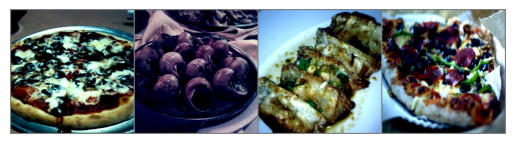

Real labels:  pizza not_pizza not_pizza pizza
Predicted:  pizza not_pizza not_pizza pizza


In [140]:
visualize_preds(model_conv)

[ref]: #top
[Back to Table of Contents][ref]

<a name="Fine_Tuning"></a>
#### Phase 4: Turning our model to a Pizzaiolo
***

Even if we have achieved a relatively high accuracy on the test set of the pretrained model, further fine-tuning is crucial to optimize our model's performance. While the initial accuracy indicates a promising start, fine-tuning allows us to adapt the model to our specific pizza classification task, capturing domain-specific features and improving its robustness. By continuing the training process, we mitigate the risk of overfitting, enhance the model's generalization capabilities, and ensure its ability to handle potential shifts in the data distribution over time. Fine-tuning ensures that our model excels in capturing the intricate nuances of pizza classification, delivering accurate predictions even in real-world scenarios.

In [26]:
resnet18_ft = torchvision.models.resnet18(weights='IMAGENET1K_V1') 

num_ftrs_ft = resnet18_ft.fc.in_features

resnet18_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs_ft, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 2)  
)

params_to_update = ['layer4.0.conv1.weight', 'layer4.0.conv1.bias',
                    'layer4.0.conv2.weight', 'layer4.0.conv2.bias',
                    'layer4.1.conv1.weight', 'layer4.1.conv1.bias',
                    'layer4.1.conv2.weight', 'layer4.1.conv2.bias',
                    'fc.0.weight', 'fc.0.bias',
                    'fc.3.weight', 'fc.3.bias']

params = []
for name, param in resnet18_ft.named_parameters():
    for parameters in params_to_update:        
        if parameters in name:
            param.requires_grad = True
            params.append(param)

In [27]:
resnet18_ft = resnet18_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_resnet18_ft = optim.SGD(params,
                           lr=0.001,
                           momentum=0.9)

In [28]:
resnet18_ft = train_model_with_patience(resnet18_ft, 
                       criterion, 
                       optimizer_resnet18_ft, 
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.4790 Acc: 0.7474
validation Loss: 0.1923 Acc: 0.9209

Epoch 1/49
----------
train Loss: 0.3781 Acc: 0.8342
validation Loss: 0.1980 Acc: 0.9311

Epoch 2/49
----------
train Loss: 0.3357 Acc: 0.8622
validation Loss: 0.2344 Acc: 0.8954
Early stopping triggered.No improvement in validation loss for 2 epochs.
Training complete in 19m 16s
Best val Acc: 0.9209


In [29]:
torch.save(resnet18_ft.state_dict(), 'finetuned_pizza_classifier.pt')

In [30]:
evaluate(resnet18_ft, dataloaders['test'])

Test Accuracy: 0.9343


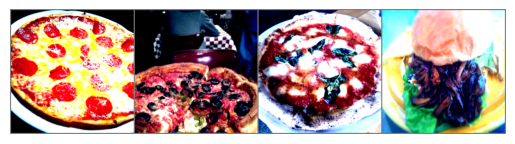

Real labels:  pizza pizza pizza not_pizza
Predicted:  pizza pizza pizza not_pizza


In [142]:
visualize_preds(resnet18_ft)

[ref]: #top
[Back to Table of Contents][ref]

#### Phase 5: Using the Pretrained Model for your own PIZZAAAAAAA!!!
***

Armed with a finely tuned pizza classification model, you possess the ability to savor the benefits of accurate and efficient pizza detection. Whether you're a pizzaiolo seeking to streamline quality control, a food blogger in search of automatic pizza tagging, or a pizza enthusiast looking to curate the most scrumptious pizza collection, this phase will guide you towards unlocking the model's potential.

In [124]:
def is_this_pizza(image):
    model = torchvision.models.resnet18(weights=False)
    num_classes = 2

    num_ftrs = model.fc.in_features

    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes)  
    )

    model.load_state_dict(torch.load("finetuned_pizza_classifier.pt"))
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5573784, 0.42671558, 0.3222913],
                             std=[0.25985646, 0.2596772, 0.264706])
    ])
    
    img = Image.open(image).convert("RGB")
    
    pic = transform(img)
    
    with torch.no_grad():
        pic = model(pic.reshape(-1, 3, 224, 224))
    _, predicted = torch.max(pic, dim=1)
    
    class_names = ['not_pizza', 'pizza']    
    
    if class_names[predicted] == 'pizza':
        print('It is a PIZZAAAAAA 🍕')
    else:
        print('It is not a pizza 🙁')
        
    plt.axis('off')
    plt.imshow(img)
    plt.title('SLICE or NOT?');

Let's see if our model can detect individual slices!

It is a PIZZAAAAAA 🍕


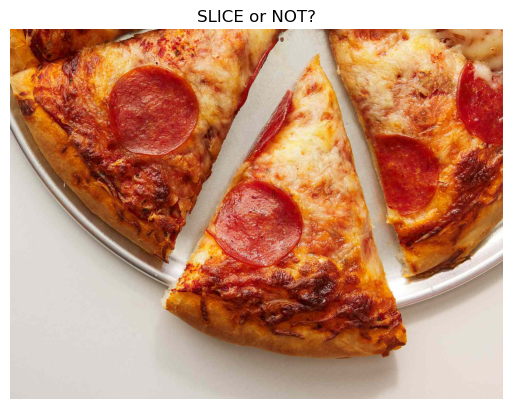

In [127]:
is_this_pizza('sample_image/my_pizza.jpg')

How about a whole pizza?

It is a PIZZAAAAAA 🍕


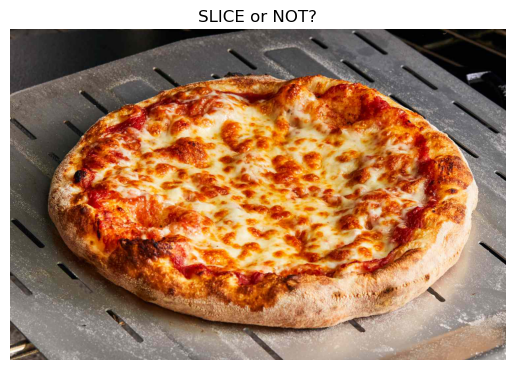

In [128]:
is_this_pizza('sample_image/my_pizza2.jpg')

Let's try it on something that isn't a pizza. An easy one.

It is not a pizza 🙁


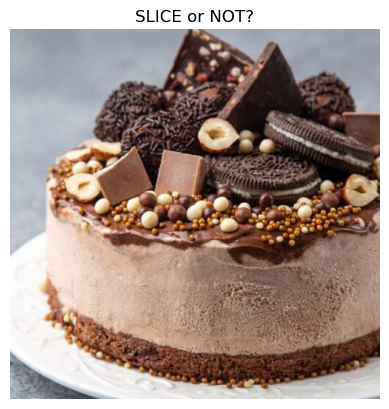

In [129]:
is_this_pizza('sample_image/cake.jpg')

Now a hard one. Buko pie closely resembles a pizza but it really isn't!

It is not a pizza 🙁


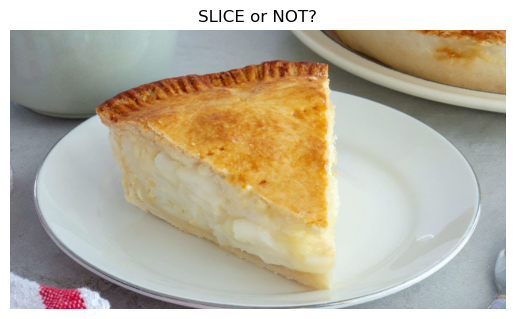

In [132]:
is_this_pizza('sample_image/buko_pie.jpg')

We have successfully created a deep learning model that satisfies both our cravings and our desire for knowledge! As we bring our journey to a close, we reflect on the incredible odyssey of building and fine-tuning our deep learning model for pizza classification. From dataset preparation to feature extraction and the art of fine-tuning, we have witnessed the transformative power of deep learning in unraveling the delicious secrets hidden within images. Through meticulous experimentation, we have sculpted a model that can discern the mouthwatering allure of pizza with remarkable accuracy. Our model is now equipped to traverse the vast world of culinary delights, showcasing its expertise in distinguishing pizza from non-pizza images. As we take our final bite, we are reminded that the journey of deep learning is ever-evolving, with new challenges and opportunities awaiting us. Armed with our newfound knowledge and the aroma of success, we step forward, hungry for further explorations in the tantalizing realm of artificial intelligence. Thank you for joining us on this captivating adventure, and may your future endeavors be as flavorful and rewarding as the perfect slice of pizza.

[ref]: #top
[Back to Table of Contents][ref]

#### References:

[1] PyTorch. (n.d.). torchvision.models.resnet50. Retrieved from https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html

[2] PyTorch. (n.d.). torchvision.models.resnet18. Retrieved from https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

[3] Encyclopædia Britannica. (n.d.). Pizza. In Encyclopædia Britannica. Retrieved from https://www.britannica.com/topic/pizza

[4] WebMD. (n.d.). What Is Pizza Made Of? In WebMD. Retrieved from https://www.webmd.com/food-recipes/what-is-pizza-made-of

[ref]: #top
[Back to Table of Contents][ref]